![banner](https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/refs/heads/main/sesiones/sesion10/sesion10_banner.png)

# **Sesión 10: Optimización 🚀📈**

# Tabla de Contenidos
1. [Introducción a la Optimización](#introducción-a-la-optimización)
2. [Cargar Imagen y Preprocesar](#cargar-imagen-y-preprocesar)
3. [Crear el Filtro Gaussiano 2D](#crear-el-filtro-gaussiano-2d)
4. [Construir la Matriz de Convolución](#construir-la-matriz-de-convolución)
5. [Aplicar el Filtro](#aplicar-el-filtro)
6. [Recuperar Imagen](#recuperar-imagen)
7. [Error de Reconstrucción](#error-de-reconstrucción)
8. [Visualización Final](#visualización-final)

In [3]:
# @title Importar librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from skimage.transform import resize
from scipy.signal import convolve2d
from numpy.linalg import pinv
from sklearn.metrics import mean_squared_error

# Introducción a la Optimización
La optimización es un área fundamental en matemáticas y ciencias computacionales que busca encontrar la mejor solución a un problema dado, minimizando o maximizando una función objetivo bajo ciertas restricciones. En el contexto del procesamiento de imágenes, la optimización nos permite resolver problemas como la restauración de imágenes, donde buscamos recuperar una imagen original a partir de una versión distorsionada o ruidosa. En este laboratorio, exploraremos cómo aplicar técnicas de optimización para recuperar imágenes desenfocadas utilizando la pseudoinversa de un operador lineal.

# Desenfocado y recuperación mediante pseudoinversa

Vamos a simular un desenfoque óptico mediante convolución con un filtro gaussiano,  y luego trataremos de recuperar la imagen original usando la pseudoinversa del operador lineal que representa dicha convolución.

## Formulación matemática general

El problema de desenfoque se puede formular como un sistema lineal:

$$y = Hx + n$$

donde:
- $x \in \mathbb{R}^n$ es la imagen original (vectorizada)
- $H \in \mathbb{R}^{m \times n}$ es la matriz que representa el operador de convolución (desenfoque)
- $y \in \mathbb{R}^m$ es la imagen desenfocada (observada)
- $n \in \mathbb{R}^m$ es un posible ruido (que en este caso ignoraremos)

  ## Cargar imagen y preprocesar







  Cargamos una imagen y la convertimos a escala de grises para trabajar con una sola matriz de valores. Redimensionaremos la imagen a un tamaño pequeño para poder manipular la matriz $H$ más fácilmente.







  Matemáticamente, representamos la imagen como una matriz $I \in \mathbb{R}^{h \times w}$, donde $h$ y $w$ son la altura y anchura respectivamente. Para el procesamiento, vectorizamos esta matriz a un vector columna $x \in \mathbb{R}^n$ donde $n = h \times w$.

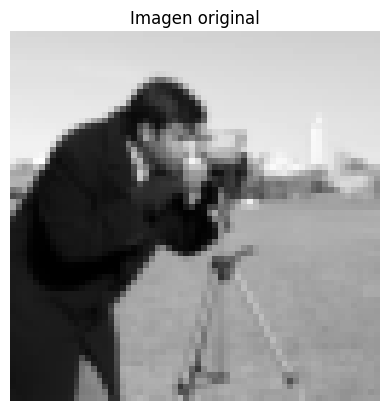

In [4]:
# Cargar imagen y convertir a escala de grises
image = data.camera()

image = resize(image, (64, 64))

x_original = image.flatten()

plt.imshow(image, cmap="gray")
plt.title("Imagen original")
plt.axis("off")
plt.show()


  ## Crear el filtro gaussiano 2D

  El filtro gaussiano 2D utilizado para el desenfoque se define como:

  $$G(x,y) = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$$

  donde:
  - $(x,y)$ son las coordenadas espaciales
  - $\sigma$ es la desviación estándar que controla el grado de desenfoque

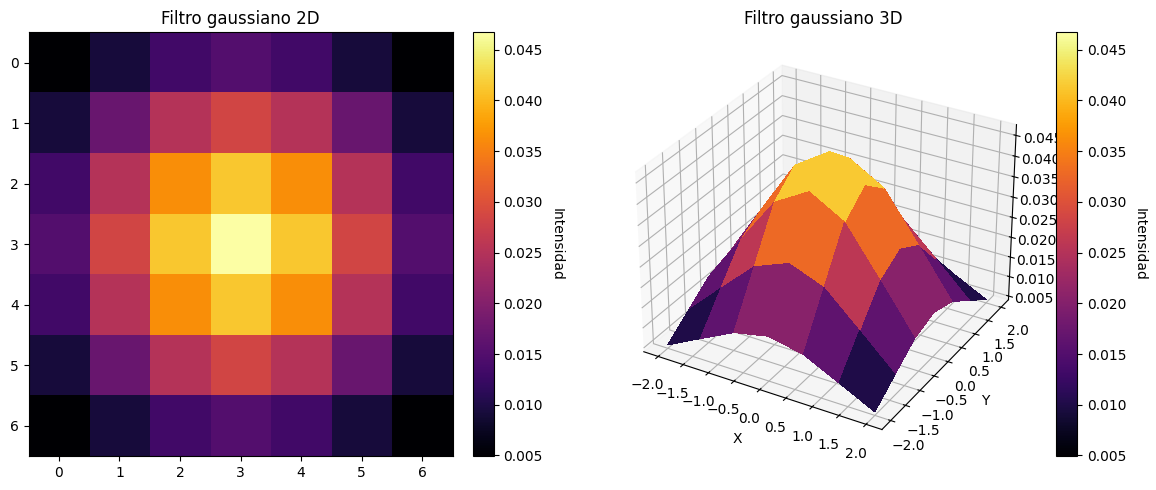

In [5]:
# Filtro gaussiano en forma de matriz 2D
def gaussian_filter(size, sigma):
    """Genera un filtro gaussiano 2D."""
    x = np.linspace(-size // 2 + 1, size // 2, size)
    y = np.linspace(-size // 2 + 1, size // 2, size)
    X, Y = np.meshgrid(x, y)
    g = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    return g / g.sum()


gaussian_kernel = gaussian_filter(7, 2.0)

cmap = "inferno"


# Visualización 2D y 3D del filtro en una sola figura 1x2, cada una con su propia barra de color
fig = plt.figure(figsize=(12, 5))


X, Y = np.meshgrid(
    np.linspace(-2, 2, gaussian_kernel.shape[0]),
    np.linspace(-2, 2, gaussian_kernel.shape[1]),
)

# 2D
ax1 = fig.add_subplot(1, 2, 1)
im = ax1.imshow(
    gaussian_kernel,
    cmap=cmap,
    vmin=gaussian_kernel.min(),
    vmax=gaussian_kernel.max(),
)
ax1.set_title("Filtro gaussiano 2D")
ax1.axis("on")
cbar1 = fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
cbar1.ax.set_ylabel("Intensidad", rotation=270, labelpad=15)

# 3D
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
surf = ax2.plot_surface(
    X,
    Y,
    gaussian_kernel,
    cmap=cmap,
    vmin=gaussian_kernel.min(),
    vmax=gaussian_kernel.max(),
    linewidth=0,
    antialiased=False,
)
ax2.set_title("Filtro gaussiano 3D")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Intensidad")
cbar2 = fig.colorbar(surf, ax=ax2, fraction=0.046, pad=0.04)
cbar2.ax.set_ylabel("Intensidad", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


  ## Construir la matriz de convolución \( H \)

Representamos la operación de convolución como una multiplicación matricial. Para esto construimos la matriz $H \in \mathbb{R}^{n \times n}$ donde $n = h \times w$ es el número total de píxeles.

Cada columna $j$ de $H$ representa el resultado de convolucionar el kernel gaussiano con una imagen que tiene un único píxel activo en la posición $j$. Matemáticamente, si $e_j$ es un vector con un 1 en la posición $j$ y 0 en el resto:

$$H[:,j] = G * e_j$$

donde $*$ representa la operación de convolución y $G$ es nuestro kernel gaussiano.

In [6]:
h, w = image.shape
n = h * w

# Construir H como operador lineal de convolución
# Cada fila de H representa aplicar el filtro gaussiano a una imagen base con un 1 en una sola posición

H = np.zeros((n, n))

for i in range(n):
    impulse = np.zeros((h, w))
    impulse[i // w, i % w] = 1.0
    filtered = convolve2d(impulse, gaussian_kernel, mode="same", boundary="wrap")
    H[:, i] = filtered.flatten()


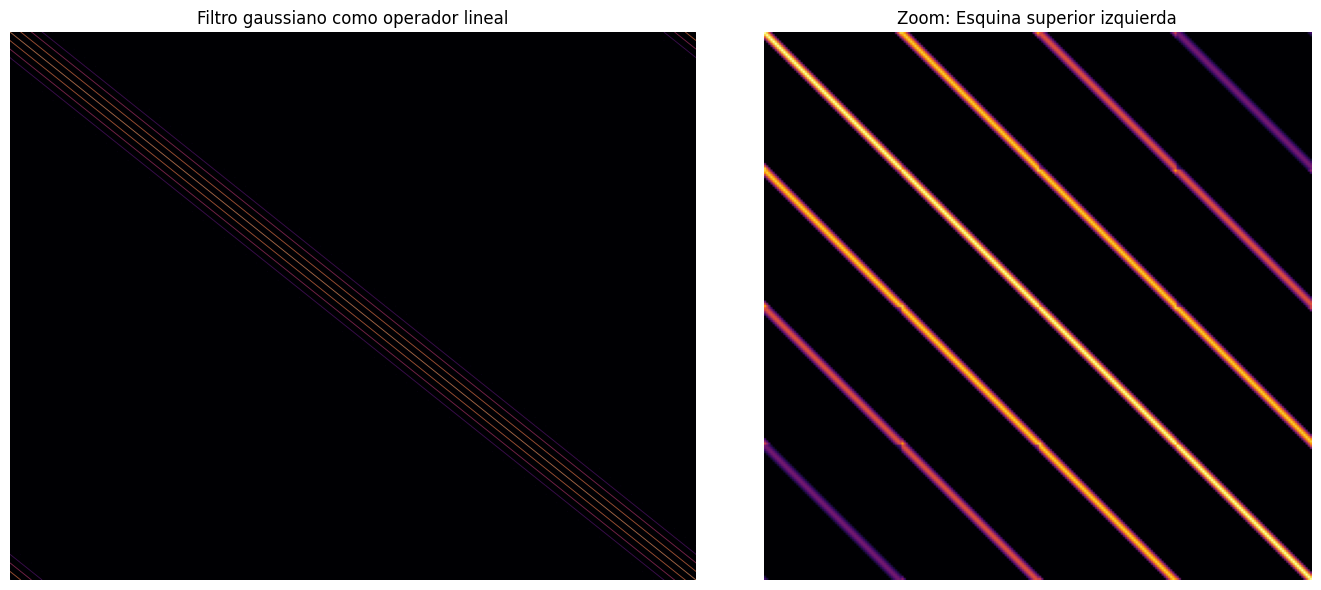

In [7]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(H, cmap="inferno", aspect="auto")
plt.title("Filtro gaussiano como operador lineal")
plt.axis("off")

# Zoom sobre la esquina superior izquierda (primeros 10x10 píxeles)
plt.subplot(1, 2, 2)
plt.imshow(H[:255, :255], cmap="inferno", aspect="equal")
plt.title("Zoom: Esquina superior izquierda")
plt.axis("off")

plt.tight_layout()
plt.show()


  ## Aplicar el filtro como producto lineal: \( y = Hx \)







  Una vez construida la matriz $H$, podemos representar la operación de desenfoque



  como una simple multiplicación matricial:







  $$y = Hx$$







  donde:



  - $x \in \mathbb{R}^n$ es la imagen original vectorizada



  - $H \in \mathbb{R}^{n \times n}$ es nuestra matriz de convolución



  - $y \in \mathbb{R}^n$ es la imagen desenfocada resultante







  Esta formulación nos permite visualizar el desenfoque como una transformación lineal.

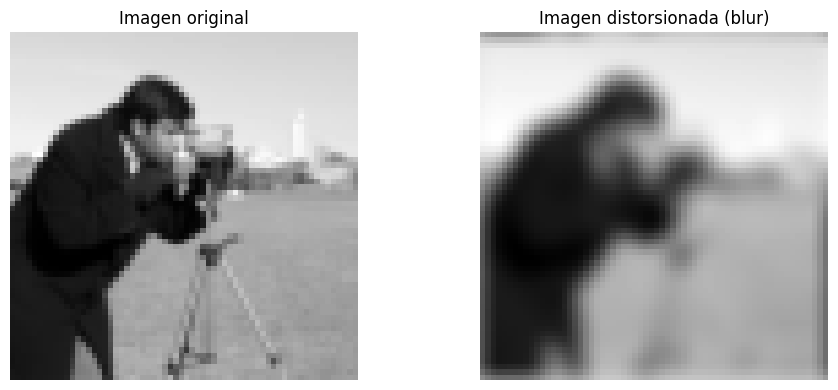

In [8]:
y = H @ x_original
y_image = y.reshape((h, w))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Imagen original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(y_image, cmap="gray")
plt.title("Imagen distorsionada (blur)")
plt.axis("off")

plt.tight_layout()
plt.show()

  ## Recuperar imagen mediante pseudoinversa

Para recuperar la imagen original a partir de la imagen desenfocada, necesitamos resolver el sistema lineal $y = Hx$ para $x$.

Como $H$ puede no ser invertible directamente (puede ser singular o estar mal condicionada), utilizamos la pseudoinversa de Moore-Penrose, denotada como $H^+$:

$$
\hat{x} = H^+ y
$$

Esta solución minimiza la norma euclídea $\|y - H\hat{x}\|_2$, es decir, resuelve el problema de mínimos cuadrados:

$$
\min_x \|y - Hx\|_2^2
$$

La solución cerrada viene dada por la pseudoinversa:

$$
\hat{x} = H^+ y
$$

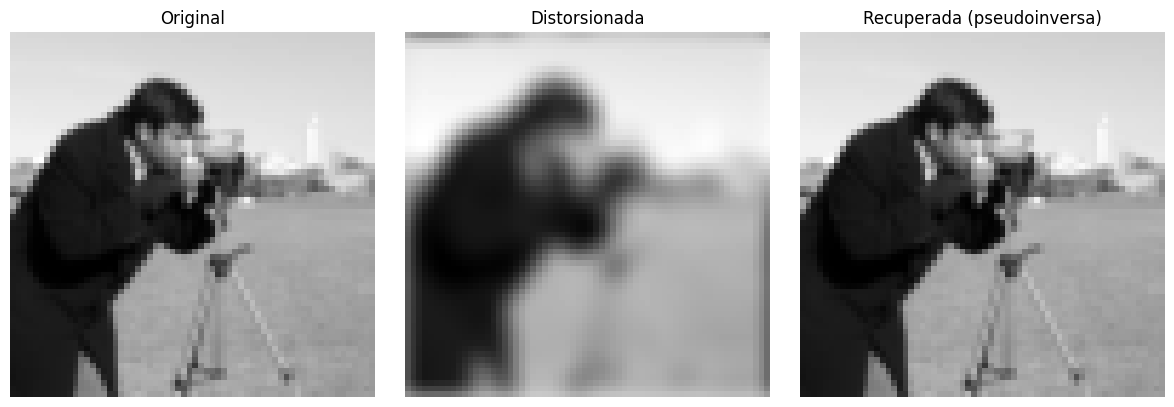

In [9]:
x_hat = pinv(H) @ y
x_hat_image = x_hat.reshape((h, w))

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(y_image, cmap="gray")
plt.title("Distorsionada")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(x_hat_image, cmap="gray")
plt.title("Recuperada (pseudoinversa)")
plt.axis("off")

plt.tight_layout()
plt.show()

  ## Error de reconstrucción







  Para evaluar la calidad de la reconstrucción, utilizamos el Error Cuadrático Medio (MSE):







  $$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (x_i - \hat{x}_i)^2 = \frac{1}{n} \|x - \hat{x}\|_2^2$$







  donde:



  - $x$ es la imagen original



  - $\hat{x}$ es la imagen reconstruida



  - $n$ es el número total de píxeles







  Un MSE más bajo indica una mejor reconstrucción. En un caso ideal (sin pérdida de información



  en el proceso de convolución), obtendríamos MSE = 0.

In [12]:
mse = mean_squared_error(x_original, x_hat)
print(f"Error cuadrático medio (MSE): {mse:.6f}")


Error cuadrático medio (MSE): 0.000000


 ## Visualización final: Proceso completo



 A continuación, mostramos el proceso completo de desenfoque y recuperación en una sola figura:

 1. Imagen original

 2. Filtro gaussiano utilizado

 3. Imagen desenfocada (distorsionada)

 4. Imagen recuperada mediante pseudoinversa

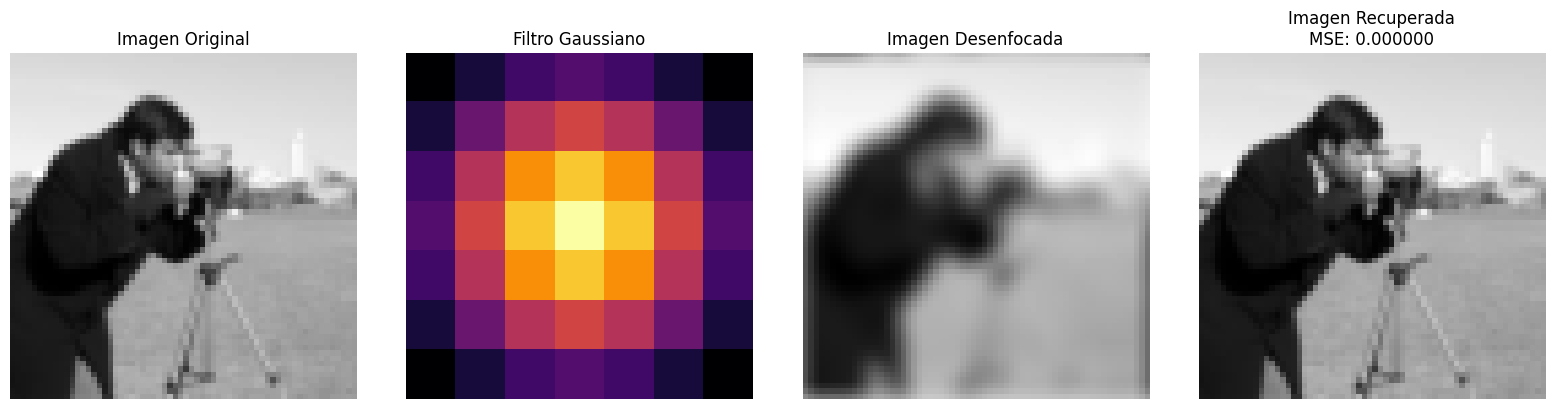

In [13]:
# Crear visualización final con todas las imágenes
plt.figure(figsize=(16, 4))

# 1. Imagen original
plt.subplot(1, 4, 1)
plt.imshow(image, cmap="gray")
plt.title("Imagen Original")
plt.axis("off")

# 2. Filtro gaussiano
plt.subplot(1, 4, 2)
plt.imshow(gaussian_kernel, cmap="inferno")
plt.title("Filtro Gaussiano")
plt.axis("off")

# 3. Imagen desenfocada
plt.subplot(1, 4, 3)
plt.imshow(y_image, cmap="gray")
plt.title("Imagen Desenfocada")
plt.axis("off")

# 4. Imagen recuperada
plt.subplot(1, 4, 4)
plt.imshow(x_hat_image, cmap="gray")
plt.title(f"Imagen Recuperada\nMSE: {mse:.6f}")
plt.axis("off")

plt.tight_layout()
plt.show()
